In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.patches as patches

In [2]:
df_basket = pd.read_csv("../input/ecommerce-sales-dataset/basket_details.csv", parse_dates = ["basket_date"])
df_details = pd.read_csv("../input/ecommerce-sales-dataset/customer_details.csv")

##  1a. Overview of Datasets : Basket
There are **15,000 rows** of collected data, from **20th May 2019 to 19th June 2019** (~1 month). It records number of transaction by a customer per day. **3,871 unique customers** has made a transaction during this one month period, with the **highest** number of items bought being **10/day** and **average transaction of ~2-3/day**. **13,161 types** of products have been bought during this period.

In [3]:
df_basket.head()

,customer_id,product_id,basket_date,basket_count
0,42366585,41475073,2019-06-19,2
1,35956841,43279538,2019-06-19,2
2,26139578,31715598,2019-06-19,3
3,3262253,47880260,2019-06-19,2
4,20056678,44747002,2019-06-19,2


In [4]:
#number of unique customer 
df_basket.customer_id.nunique()

#number of unique products bought 
df_basket.product_id.nunique()

#period in which data is collected 
df_basket.basket_date.max()
df_basket.basket_date.min()

Timestamp('2019-05-20 00:00:00')

In [5]:
#total rows of collected data 
#average, highest and lowest number of transaction in a day 
#ensure that there are no null values in the dataset
df_basket.basket_count.describe()

count    15000.000000
mean         2.153733
std          0.517929
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: basket_count, dtype: float64

In [6]:
#ensure that there are no null values in the dataset
df_basket.isnull().sum()

customer_id     0
product_id      0
basket_date     0
basket_count    0
dtype: int64

##  1b. Overview of Datasets : Customer Details

20,000 unique customers has been registered under the E-commerce platform. However, there is something wrong as describe() function returns a **average age of 262 and max age of 2022**. There is **1 user with age -34**, **6,702 users with age over 110** and **2102 users with ages 2022**. We are unable to determine the correct age of users at this stage. However, we can reduce the total number of data points by removing/ filtering out these users with incorrect ages. 

In [7]:
df_details.head()

,customer_id,sex,customer_age,tenure
0,9798859,Male,44.0,93
1,11413563,Male,36.0,65
2,818195,Male,35.0,129
3,12049009,Male,33.0,58
4,10083045,Male,42.0,88


In [8]:
#number of unique customer registered under ecommerce platform
df_details.customer_id.nunique()

20000

In [9]:
#overview of the dataset
#noticed that min, mean and max age is incorrect
df_details.describe()

,customer_id,customer_age,tenure
count,2.000000e+04,20000.000000,20000.000000
mean,1.760040e+07,262.222550,44.396800
std,8.679505e+06,604.321589,31.998376
min,2.093000e+03,-34.000000,4.000000
25%,1.188115e+07,29.000000,21.000000
50%,1.560912e+07,38.000000,35.000000
75%,2.228484e+07,123.000000,60.000000
max,4.462566e+07,2022.000000,133.000000


In [10]:
#number of users with ages less than 0
len(df_details[(df_details.customer_age < 0)])

1

In [11]:
#number of users with ages 2022
len(df_details[(df_details.customer_age == 2022)])

2102

## 2. Weightage of Wrong VS Correct User Ages
a. In the details dataset there are users with incorrect ages. This would produce an incorrect result/ analysis if we were to do visualisation showing transaction by age distribution. First lets **look at the age distribution to have an overall sensing**. It seems like we have a **handful of users with age more than 1500**. Lets **filter out this** so we can look at a less skewed age distribution. 

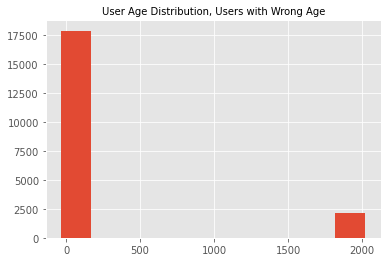

In [12]:
plt.style.use("ggplot")

plt.hist(df_details.customer_age)
plt.title("User Age Distribution, Users with Wrong Age", size = 10)
plt.show()

b. We also have a handful of users wieh age that is at the **110 - 125 range**. Lets **filter out these users (and also the user with -34 age)** so that we can have a more accurate overview of the remaining data. 

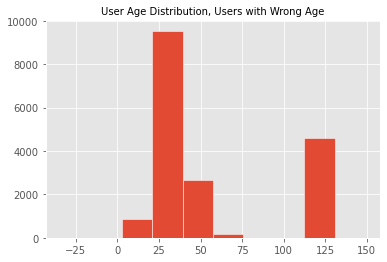

In [13]:
plt.hist(df_details[df_details.customer_age < 1500]["customer_age"], edgecolor = "white")
plt.title("User Age Distribution, Users with Wrong Age", size = 10)
plt.show()

c. The age distribution seems correct here, with users between the age of **5 to 70**. However, there could still be users with **ages 0-5 and 70-100**, that does not appear on the histogram chart as the ages are **too skewed towards ages 25-30**. Lets do a logarithmic graph to have a clearer visualisation.

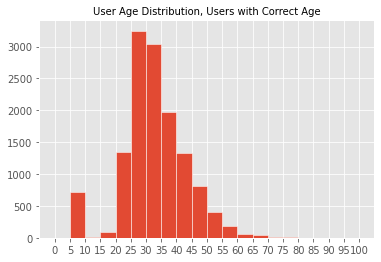

In [14]:
bins = np.arange(0,105,5).tolist()

plt.hist(df_details[df_details.customer_age.between(0,100)]["customer_age"], bins = bins, edgecolor = "white")
plt.xticks(bins)

plt.title("User Age Distribution, Users with Correct Age", size = 10)
plt.show()

d. It seems like we **do have users from age 0 to 5 and 70-100**. However, are users with **ages 0-5 be old enough** to register an account in the ecommerce platform? Do we need to filter these groups of users out? Lets keep the dataset and weight the overall proportion/ percentages of correct data against wrong data. 

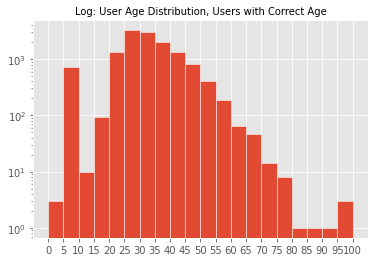

In [15]:
bins = np.arange(0,105,5).tolist()

plt.hist(df_details[df_details.customer_age.between(0,100)]["customer_age"], bins = bins, edgecolor = "white",
        log = True)
plt.xticks(bins)

plt.title("Log: User Age Distribution, Users with Correct Age", size = 10)
plt.show()

In [16]:
age_100_above = len(df_details[df_details.customer_age > 100])
age_6_100 = len(df_details[df_details.customer_age.between(6,100)])
age_5 = len(df_details[df_details.customer_age.between(0,5)])
age_less_0 = len(df_details[df_details.customer_age < 0])

e. There are more than 6707 users with incorrect ages, which is about ~50 of users with correct age. **If we were to exclude users with incorrect ages when doing subsequent analysis, we would be excluding 1/3 of the entire dataset**. If we were to conduct an analysis to look at any correlation with any attributes with ages, then we would have to use ages 6-100 for a more accurate representation. 

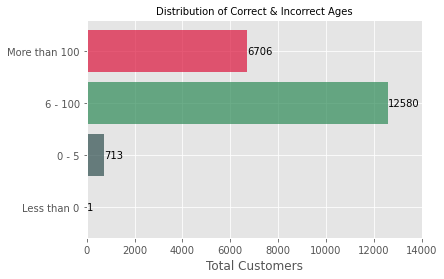

In [17]:
age = [age_100_above, age_6_100, age_5, age_less_0]
age_cat = ["More than 100", "6 - 100", "0 - 5", "Less than 0"]

age.reverse()
age_cat.reverse()

palette = ["maroon", "darkslategrey", "seagreen", "crimson"]

fig, ax = plt.subplots()

hbars = ax.barh(age_cat, age, color = palette, alpha = 0.7)

ax.bar_label(hbars, fmt='%.0f')

x_tick = np.arange(0,16000, 2000).tolist()
ax.set_xticks(x_tick)
plt.xlabel("Total Customers")

plt.title("Distribution of Correct & Incorrect Ages", size = 10)

plt.show()

## 3. Working with Invalid/ Incorrect Data 
**Correlation between Ages, Sex and Tenure of Customers**

a. Previously, we have discovered that there are a handful of customers with invalid ages. However, in order to do an analysis involving correlation between ages, sex and tenure, we would have to **use valid data**. We would **till have a total of 12,580 /20,000 which is still accetable and a large number of customers**. 

In [18]:
#filtering users with correct ages 
df_details_1 = df_details[df_details.customer_age.between(6,100)]
df_details_1.head()

,customer_id,sex,customer_age,tenure
0,9798859,Male,44.0,93
1,11413563,Male,36.0,65
2,818195,Male,35.0,129
3,12049009,Male,33.0,58
4,10083045,Male,42.0,88


b. There are **9 rows of invalid data**, 8 with "kvkktalepsilindi" and 1 "UKNOWN". 

In [19]:
#check sex to ensure no invalid cells 
df_sex = df_details_1.sex.value_counts()
df_sex

Male                9392
Female              3179
kvkktalepsilindi       8
UNKNOWN                1
Name: sex, dtype: int64

In [20]:
#taking fields with only "Female" and "Male" under sex attribute
df_details_1 = df_details_1[(df_details_1.sex == "Female") | (df_details_1.sex == "Male")]
df_details_1.head()

,customer_id,sex,customer_age,tenure
0,9798859,Male,44.0,93
1,11413563,Male,36.0,65
2,818195,Male,35.0,129
3,12049009,Male,33.0,58
4,10083045,Male,42.0,88


In [21]:
#convert tenure to years 
df_details_1["tenure"] = df_details_1["tenure"].astype("float")
df_details_1["tenure_year"] = [round(i/12,1) for i in df_details_1["tenure"]]

df_details_1.describe()

,customer_id,customer_age,tenure,tenure_year
count,1.257100e+04,12571.000000,12571.000000,12571.000000
mean,1.577671e+07,33.757776,53.197598,4.431143
std,8.510168e+06,8.870829,35.068828,2.927074
min,2.093000e+03,6.000000,4.000000,0.300000
25%,1.053723e+07,27.000000,25.000000,2.100000
50%,1.370424e+07,32.000000,44.000000,3.700000
75%,2.031176e+07,39.000000,78.000000,6.500000
max,4.462178e+07,100.000000,133.000000,11.100000


c. There are **more males than females** using the E-commerce platform. For tenure and age distribution, **both genders** have most user in their **late twenties (25-29)** who are registered with the platform for **2 years**. The second higheest group will be those in their **early thirties (30-35)**, who are registered with the platform for **8 years**. 

<Figure size 720x360 with 0 Axes>

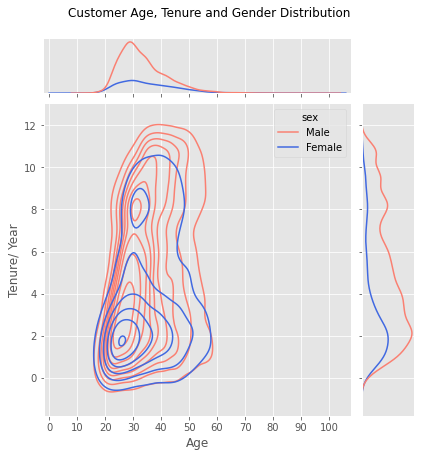

In [22]:
plt.figure(figsize = (10,5))

g = sns.jointplot(data = df_details_1,
              x = "customer_age", y = "tenure_year",
              hue = "sex",
              kind = "kde",
              palette = ["salmon", "royalblue"])

x_ticks = np.arange(0,110,10).tolist()

g.ax_joint.set_xticks(x_ticks)

g.fig.suptitle("Customer Age, Tenure and Gender Distribution", y = 1.05)

g.ax_joint.set_xlabel("Age")
g.ax_joint.set_ylabel("Tenure/ Year")

plt.show()

## 4. Registered VS Non-Registered Customers Who Made Purchases

In [23]:
#left join on customer id attribute/ column 
df_basket["customer_id"] = df_basket["customer_id"].astype("str")
df_details["customer_id"] = df_details["customer_id"].astype("str")
df_overall = pd.merge(df_basket, df_details, how = "left", left_on = "customer_id", right_on = "customer_id")
df_overall.head()

,customer_id,product_id,basket_date,basket_count,sex,customer_age,tenure
0,42366585,41475073,2019-06-19,2,NaN,NaN,NaN
1,35956841,43279538,2019-06-19,2,NaN,NaN,NaN
2,26139578,31715598,2019-06-19,3,NaN,NaN,NaN
3,3262253,47880260,2019-06-19,2,NaN,NaN,NaN
4,20056678,44747002,2019-06-19,2,NaN,NaN,NaN


a. We expected that the number of customer id in df_basket would be a subset of custoer id in df_details because df_baskets contains all the customer's detail information. However, this is not the case! We have 14,928 our of 15000 rows that are NaN,m which means the customer id in df_basket could not be found in df_details. 

What does this mean? Could it be that there are errors in the df_details dataset? Could it be that customers not registered under ecommerce platform could also conduct transactions and given random customer ids? Lets assume that this is the case, and we can look at number of registered and unregistered customers. 

In [24]:
#overall number of rows with NaN fields
df_null = df_overall.isnull().sum().rename_axis("column").reset_index(name = "count")
df_null

,column,count
0,customer_id,0
1,product_id,0
2,basket_date,0
3,basket_count,0
4,sex,14928
5,customer_age,14928
6,tenure,14928


In [25]:
#determine number of unique users with and without customer_id in df_details
df_overall_notnull = df_overall[df_overall.sex.notnull()]
overall_notnull = df_overall_notnull["customer_id"].nunique()

df_overall_null = df_overall[df_overall.sex.isnull()]
overall_null = df_overall_null["customer_id"].nunique()

b. We have ~13,800 unregistered against 64 registered customers. This is quite shocking as the total transactions made on the Ecommerce platform is by customers who do not have an account. This also mean that out of 20,000 registered customers, only 64 made transactions. 

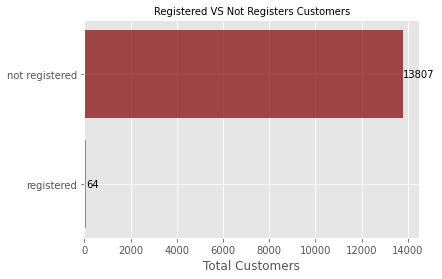

In [26]:
customers = [overall_notnull, overall_null]
customer_cat = ["registered", "not registered"]

palette = ["seagreen", "maroon"]

fig, ax = plt.subplots()

hbars = plt.barh(customer_cat, customers, color = palette, alpha = 0.7)

ax.bar_label(hbars, fmt='%.0f')

plt.title("Registered VS Not Registers Customers", size = 10)

plt.xlabel("Total Customers")

plt.show()

## 5. Unregistered Customers Transactions Trend

In [27]:
#filter out unregistered customers and remove unecessary column
df_unregistered = df_overall_null.drop(["sex", "customer_age", "tenure"], axis = 1)
df_unregistered.head()

,customer_id,product_id,basket_date,basket_count
0,42366585,41475073,2019-06-19,2
1,35956841,43279538,2019-06-19,2
2,26139578,31715598,2019-06-19,3
3,3262253,47880260,2019-06-19,2
4,20056678,44747002,2019-06-19,2


In [28]:
# ur = unregistered 
# find total number of transactions done per day 
df_ur_transaction = df_unregistered.groupby("basket_date")["basket_count"].sum().reset_index(name = "transactions")
df_ur_transaction.sort_values("basket_date", inplace = True)

#find total number of users per day 
df_ur_customer = df_unregistered.groupby("basket_date")["customer_id"].count().reset_index(name = "number_of_customers")
df_ur_customer.sort_values("basket_date", inplace = True)

df_ur_customer.head()

,basket_date,number_of_customers
0,2019-05-20,516
1,2019-05-21,451
2,2019-05-22,272
3,2019-05-23,274
4,2019-05-24,605


a. The total number of transactions and customers on the E-commerce platform peaked near the end of the month (25th-28th May 2019). There were also presence of slight peaks from 8-11th June 2019 and 14-16th June 2019. Lets narrow down to see if there are any noticeable trend per week. 

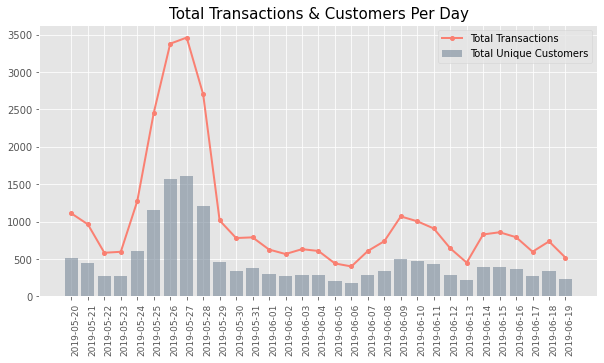

In [29]:
plt.figure(figsize = (10,5))

plt.plot(df_ur_transaction.basket_date, df_ur_transaction.transactions, marker = "o",
         markersize = 4, color = "salmon", linewidth = 2, label = "Total Transactions")
plt.bar(df_ur_customer.basket_date, df_ur_customer.number_of_customers, color = "lightslategrey", 
        alpha = 0.6, label = "Total Unique Customers")

x_label = df_ur_customer.basket_date.tolist()

plt.xticks(x_label, rotation = 90, size = 9, ha = "left")

plt.title("Total Transactions & Customers Per Day", size = 15)

plt.legend()

plt.show()

In [30]:
#add new column showing day of week
df_ur_transaction["day_of_week"] = df_ur_transaction["basket_date"].dt.strftime('%a')

#rank the weeks 
df_ur_transaction["week_rank"] = df_ur_transaction.groupby("day_of_week")["basket_date"].rank(method = "first")

#week 5 has data only from mon - wed
#we will remove it from the plot 
df_ur_transaction_1 = df_ur_transaction[df_ur_transaction.week_rank != 5]

df_ur_transaction_1.head(10)

,basket_date,transactions,day_of_week,week_rank
0,2019-05-20,1110,Mon,1.0
1,2019-05-21,964,Tue,1.0
2,2019-05-22,584,Wed,1.0
3,2019-05-23,597,Thu,1.0
4,2019-05-24,1275,Fri,1.0
5,2019-05-25,2455,Sat,1.0
6,2019-05-26,3380,Sun,1.0
7,2019-05-27,3462,Mon,2.0
8,2019-05-28,2703,Tue,2.0
9,2019-05-29,1016,Wed,2.0


b. We can see that for week 1, 3 and 4, thursdays have the lowest volume of transaction. However, for week 2, the volume of transaction decreases through the week. This could be due to the after effects of sudden huge peak that occured on week 1 Sunday. In order to confirm this, more data should be collected and compared to. 

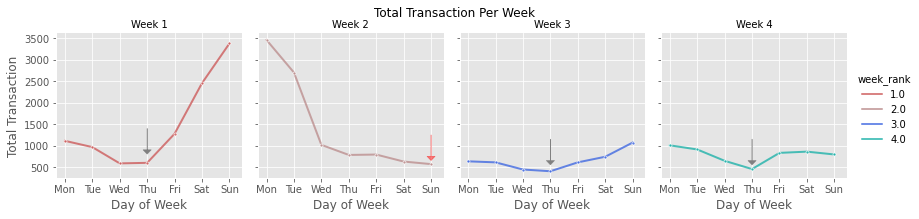

In [31]:
plt.style.use('ggplot')

palette = ["indianred", "rosybrown", "royalblue", "lightseagreen"]

g = sns.relplot(data = df_ur_transaction_1,
           x = "day_of_week", y = "transactions", 
           hue = "week_rank", col = "week_rank",
            col_wrap = 4,
           kind = "line",
           linewidth = 2,
            palette = palette,
           marker = ".", 
           alpha = 0.8, 
            height = 3,
          aspect = 1)

axes = g.axes.flatten()

title = ["Week 1", "Week 2", "Week 3", "Week 4"]
y_arrow = [1400, 1250, 1150, 1150]

#set grid style for all axes 
for i in range(len(title)):
    axes[i].set_title(title[i], size = 10)
    if i != 1:
        axes[i].arrow(3, y_arrow[i], 0, -500, head_width = 0.3,
             head_length = 100, fc ='grey', ec ='grey')
    else:
        axes[i].arrow(6, y_arrow[i], 0, -500, head_width = 0.3,
             head_length = 100, fc ='red', ec ='red', alpha = 0.5)

g.fig.suptitle("Total Transaction Per Week", y = 1)

g.set_xlabels("Day of Week")
g.set_ylabels("Total Transaction")


plt.show()

## 6. Registered Customers Transactions
a. As there are only 64 unique customers, we expect the available data points to be extremeley low as compared to unregistered customers. While conducting time series analysis, it is predicted that due to insufficient data, we will be unable to clearly identify trends. 

In [32]:
#filter out registered customers and remove unecessary column
df_registered = df_overall_notnull.sort_values("basket_date")
df_registered.head()

,customer_id,product_id,basket_date,basket_count,sex,customer_age,tenure
9408,15141119,4033598,2019-05-20,2,Female,123.0,38.0
10423,4912369,33923115,2019-05-20,2,Male,36.0,114.0
8516,8508353,47709800,2019-05-21,2,Male,36.0,102.0
14326,14248059,48790153,2019-05-21,2,Male,29.0,41.0
9335,12737235,46373374,2019-05-21,3,Male,39.0,51.0


In [33]:
# reg = registered 
# find total number of transactions done per day 
df_reg_transaction = df_registered.groupby("basket_date")["basket_count"].sum().reset_index(name = "transactions")
df_reg_transaction.sort_values("basket_date", inplace = True)

#find total number of users per day 
df_reg_customer = df_registered.groupby("basket_date")["customer_id"].count().reset_index(name = "number_of_customers")
df_reg_customer.sort_values("basket_date", inplace = True)

df_reg_customer.head()

,basket_date,number_of_customers
0,2019-05-20,2
1,2019-05-21,6
2,2019-05-22,4
3,2019-05-23,1
4,2019-05-24,6


In [34]:
#include all dates by left join
df_reg_customer_1 = pd.merge(df_ur_customer.basket_date.to_frame(), df_reg_customer, how = "left", left_on = "basket_date",
                            right_on = "basket_date")

#replace NaN values with 0
df_reg_customer_1.fillna(0, inplace = True)

#check that there are no NaN values 
df_reg_customer_1.isna().sum()

basket_date            0
number_of_customers    0
dtype: int64

In [35]:
#repeat for transaction 
df_reg_transaction_2 = pd.merge(df_ur_transaction.basket_date.to_frame(), df_reg_transaction, how = "left", left_on = "basket_date",
                            right_on = "basket_date")

df_reg_transaction_2.fillna(0, inplace = True)

df_reg_transaction_2.isna().sum()

basket_date     0
transactions    0
dtype: int64

b. The graph below roughly matches the time series graph for unregistered customers. However, more data needs to be collected for this group of customers in order to clearly identify any trends with highest/lowest transaction in a day.  

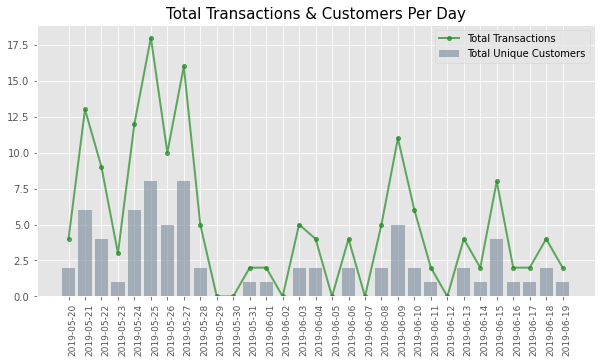

In [36]:
plt.figure(figsize = (10,5))

plt.plot(df_reg_transaction_2.basket_date, df_reg_transaction_2.transactions, marker = "o",
         markersize = 4, color = "forestgreen", linewidth = 2, alpha = 0.7, label = "Total Transactions")
plt.bar(df_reg_customer_1.basket_date, df_reg_customer_1.number_of_customers, color = "lightslategrey", 
        alpha = 0.6, label = "Total Unique Customers")

x_label = df_reg_customer_1.basket_date.tolist()

plt.xticks(x_label, rotation = 90, size = 9, ha = "left")

plt.title("Total Transactions & Customers Per Day", size = 15)

plt.legend()

plt.show()

## 7. Final Thoughts
Due to huge percentage of unmatching customer id between both datasets, **there were some analysis that we could not carry out, such as identifying whether there is a correlation between sex/ages/tenure of customer during peak and non peak periods.** 

Nevertheless, we assumed users found in df_basket and not in df_details are unregistered users and ocnducted an analysis to determine that **generally Thursdays are the days with lowest transactions**. Also a **huge peak from 25th - 28th May** could be a result of **huge sales conducted** by the e-commerce platform. 

*It is still critical to note that we have 64 registered VS 13,000 unregistered uses who have made a transaction. This also means that out of the 20000 registered users, 64 has made a transaction and ~19036 has not made any transactions. For the purpose of this analysis, we will assume this is the case. However in reality, we would have to confirm with the stakeholder as it is most likely that there is an error with df_details dataset.*

We also worked with the available data by filtering out datapoints with invalid ages and are still able to **work with ~12,000 data points, down from 20,000**. However it is advisable that the ages should reflect correct numerical values in order to reflect the true results of customer's age distribution. 

There are ** three times more male than female** users. However, both genders have **similar age and tenure distribution**, with most user in their **late twenties and early thirties**. Users in their **late twenties have about 2 years tenure** while users in **early thirties have about 8 years tenure**. 
